In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import re
import seaborn as sns
from datetime import datetime
from collections import Counter
import warnings


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
job_list_full = pd.read_table('july-2017-thru-june-2018.txt',sep='|',dtype='str')

## Question 1: Finding Correlations Among the Amount of Requested RAM, Queue Length, and Wall Time

### Part 1: Finding Correlation Between the Amount of RAM and Queue Length

#### Uncomment if testing with random samples from the same log file. Comment out the line above.

In [4]:
#job_complete_list = pd.read_table('july-2017-thru-june-2018.txt',sep='|',dtype='str')

In [5]:
#indices = np.random.randint(0,len(job_complete_list),250000)
#job_list_full = job_complete_list.iloc[indices]

In [6]:
job_list_full['Submit'] = pd.to_datetime(job_list_full['Submit'])
job_list_full['Start'] = pd.to_datetime(job_list_full['Start'])
job_list_full['queue'] = job_list_full['Start'] - job_list_full['Submit']

#### Converting queue length to a float represented by wait time in hours. 

In [7]:
job_list_full['queue'] = job_list_full['queue'].apply(lambda x: x/np.timedelta64(1,'h'))

#### Function to convert Megabytes and Terabytes into Gigabytes.

In [8]:
def units_convert(cell):
    try:
        cell = str(cell[0])
        if cell.endswith('M'):
            return int(float(cell[:-1]) / 1000)
        elif cell.endswith('T'):
            return int(float(cell[:-1]) * 1000)
        else:
            return int(float(cell[:-1]))
    except:
        return int(0)

#### Function to parse out total requested memory from ReqTRES column. Instead of calculating Total RAM by multiplying by the number of cores or nodes, we parse the total from the total requested resources column with regular expressions.

In [9]:
def parse_mem(unparsed):
    try:
        x = re.findall('\,mem=(\d+\w*)\,',unparsed)
        return x
    except:
        return '[]'

#### Parsing out total requested memory into a separate 'total_ram' column.

In [10]:
job_list_full['total_ram'] = job_list_full['ReqTRES'].apply(parse_mem)
job_list_full['total_ram'].head(5)

0      [12G]
1      [12G]
2      [12G]
3      [12G]
4    [4000M]
Name: total_ram, dtype: object

#### Converting MB and TB to GB. Converting object type to integer type to be used for the correlation function later.

In [11]:
job_list_full['total_ram'] = job_list_full['total_ram'].apply(units_convert).astype(np.int64)

#### What will the correlation be on the entire data set? Correlation between the requested RAM and queue length is very weak. Further subsetting the data to look for correlations.

In [12]:
job_list_full[['queue','total_ram']].corr(method="spearman")

,queue,total_ram
queue,1.000000,0.102105
total_ram,0.102105,1.000000


####  Let's make a scatter plot of the most popular RAM requests.

In [13]:
memory_top_20 = job_list_full['total_ram'].value_counts(ascending=False).head(20)

#### Converting value counts to two variables ready for a scatter plot.

In [14]:
x = memory_top_20.index.tolist()
y = memory_top_20.tolist()

#### The scatter plot shows that the two most popular RAM requests are around 5GB and around 30GB. We further evaluate two subsets based on this finding.

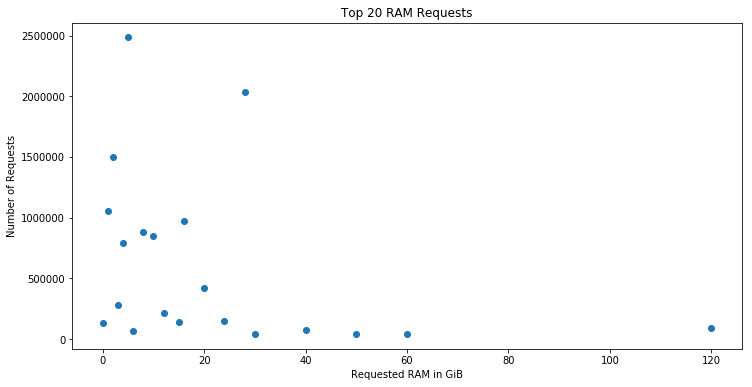

In [15]:
_ = plt.figure(figsize=(12,6))
plt.scatter(x,y);
_ = plt.xlabel('Requested RAM in GiB')
_ = plt.ylabel('Number of Requests')
_ = plt.title('Top 20 RAM Requests')

#### The second consideration is that things look pretty boring until the queue gets busy. In addition to the most frequent memory requests, queue length is used as a second parameter. For the first subset, the parameters are as follows: queue length is over 24 hours but under 110 hours. Requested amount of RAM is also a subset with the users requesting between 1GB and 6GB of RAM per process, since this range includes some of the most frequent requests (as per scatter plot above).

In [16]:
queue_24110 = job_list_full.loc[(job_list_full['queue'] > 24) & (job_list_full['queue'] < 110)]
queue_24110_ram_16 = queue_24110.loc[(queue_24110['total_ram'] > 1) & (queue_24110['total_ram'] < 6)]

#### As the queue gets more congested, there seems to be a correlation between the amount of requested memory and length time. The correlation is not very strong, but strong enough for further consideration.

In [17]:
queue_24110_ram_16[['queue','total_ram']].corr(method="spearman")

,queue,total_ram
queue,1.000000,0.599358
total_ram,0.599358,1.000000


#### What will the two variables look like on a boxplot? Different partition types (CPU vs. GPU) seem to have different effects on the queue length.

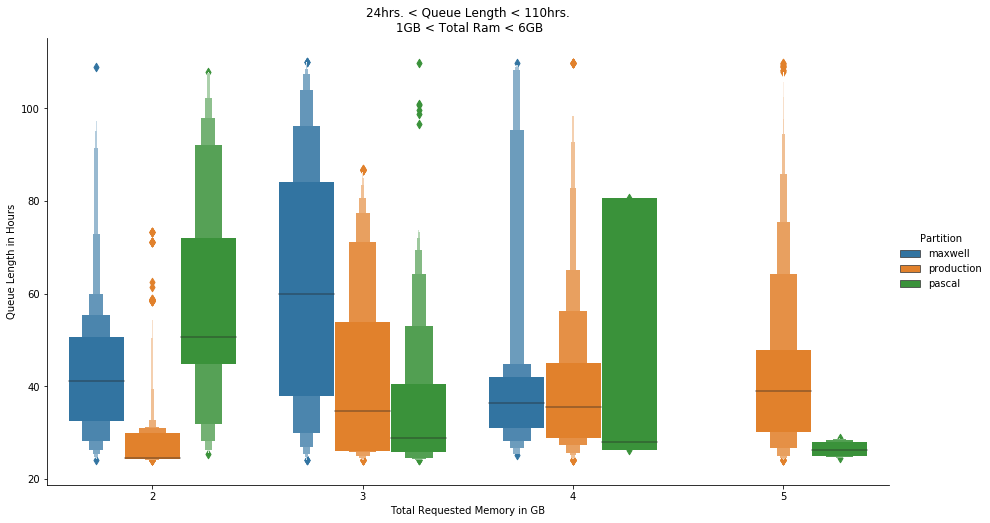

In [18]:
sns.catplot(x='total_ram', y='queue',data=queue_24110_ram_16,hue="Partition",height=7, aspect=1.8, kind='boxen');
_ = plt.title("24hrs. < Queue Length < 110hrs.\n 1GB < Total Ram < 6GB")
_ = plt.xlabel("Total Requested Memory in GB")
_ = plt.ylabel("Queue Length in Hours")

#### How many jobs do we have in this subset? Many more in production (CPU computing).

In [19]:
queue_24110_ram_16[['Partition','total_ram','JobIDRaw']].groupby(['Partition','total_ram']).agg('count').sort_values(by=['Partition','total_ram'])

JobIDRaw
Partition  total_ram          
maxwell    2               719
           3              2461
           4                37
pascal     2                56
           3              5794
           4                 5
           5               200
production 2             37834
           3              9353
           4             13597
           5             11528

#### What if we remove GPU nodes? Will it affect the relationships?

In [20]:
queue_24110_ram_16_nogpu = queue_24110_ram_16.loc[queue_24110_ram_16['Partition'] == 'production']

#### The correlation between the queue length and the amount of requested RAM becomes stronger with the GPU nodes removed.

In [21]:
queue_24110_ram_16_nogpu[['queue','total_ram']].corr(method="spearman")

,queue,total_ram
queue,1.000000,0.641281
total_ram,0.641281,1.000000


#### How does the correlation look like when plotted? A bulk of jobs is around the 2GB of requested RAM. However, these jobs do not stretch the length of the queue as much. 

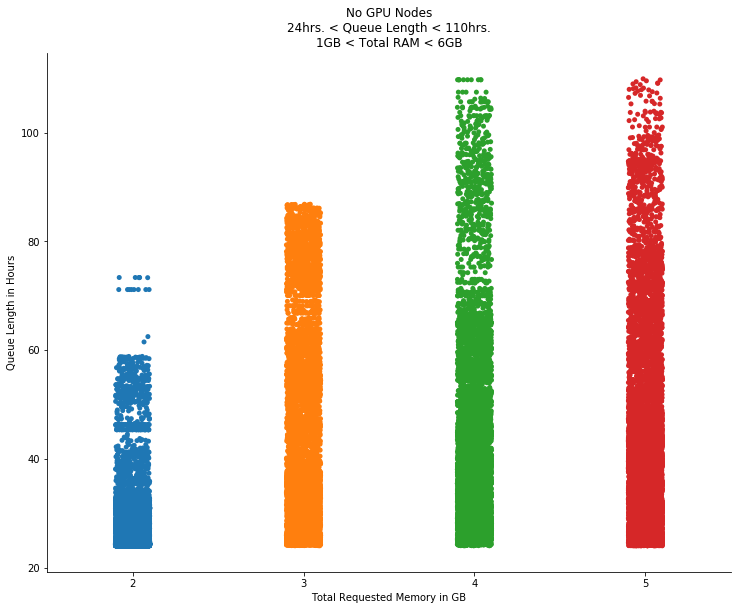

In [22]:
sns.catplot(x='total_ram', y='queue',data=queue_24110_ram_16_nogpu, height=8, aspect=1.3);
_ = plt.title('No GPU Nodes\n24hrs. < Queue Length < 110hrs.\n1GB < Total RAM < 6GB')
_ = plt.xlabel('Total Requested Memory in GB')
_ = plt.ylabel('Queue Length in Hours')

#### Significant number of jobs still present in this subset even with the GPU nodes removed.

In [23]:
queue_24110_ram_16_nogpu[['Partition','total_ram','JobIDRaw']].groupby(['Partition','total_ram']).agg('count').sort_values(by=['Partition','total_ram'])

JobIDRaw
Partition  total_ram          
production 2             37834
           3              9353
           4             13597
           5             11528

### Part 1 Bulletpoint Takeaways:
* Queue length is boring without many correlations until it gets backed up
* Vast majority of RAM requests happen just under around 5GB and around 30GB
* RAM requests correlate differently with queue length depending upon the partition type (CPU versus GPU)
* "In the beginner’s mind there are many possibilities, in the expert’s mind there are few." --Shunryu Suzuki 

## Part 2: Finding Correlation Between Wall Time (Timelimit) and Queue

#### Converting Timelimit into datetime format. Stripping off the dash and replacing it with "days", which timedelta can parse.

In [24]:
def add_days(two_formats):
    if(re.match('^\d+\-',str(two_formats))):
        return re.sub('-',' days ', str(two_formats))
    else:
        return ("0 days " + str(two_formats))

#### Converting to timedelta datatype and into hours for visualization and correlations.

In [25]:
queue_24110_ram_16_nogpu['Timelimit'] = queue_24110_ram_16_nogpu['Timelimit'].apply(add_days)
queue_24110_ram_16_nogpu['Timelimit'] = pd.to_timedelta(queue_24110_ram_16_nogpu['Timelimit'])
queue_24110_ram_16_nogpu['Timelimit'] = queue_24110_ram_16_nogpu['Timelimit'].apply(lambda x: x/np.timedelta64(1,'h'))

#### Removing outliers with Timelimit of over 150 hours

In [26]:
queue_24110_ram_16_nogpu = queue_24110_ram_16_nogpu.loc[queue_24110_ram_16_nogpu['Timelimit'] < 150]

#### Medium correlation between queue length and requested RAM. Medium correlation between queue length and requested time (Timelimit). Strong correlation between requested time (Timelimit) and requested RAM.

In [27]:
queue_24110_ram_16_nogpu[['queue','total_ram','Timelimit']].corr(method="spearman")

,queue,total_ram,Timelimit
queue,1.000000,0.641276,0.777021
total_ram,0.641276,1.000000,0.813011
Timelimit,0.777021,0.813011,1.000000


#### Visualizing the three correlations. Interesting find. Longer requested times (Timelimit) do not correlate with longer queue times when the amount of requested RAM is 4GB. However, if the amount of requested RAM is 3GB, queue length strongly correlates with the values of Timelimit.

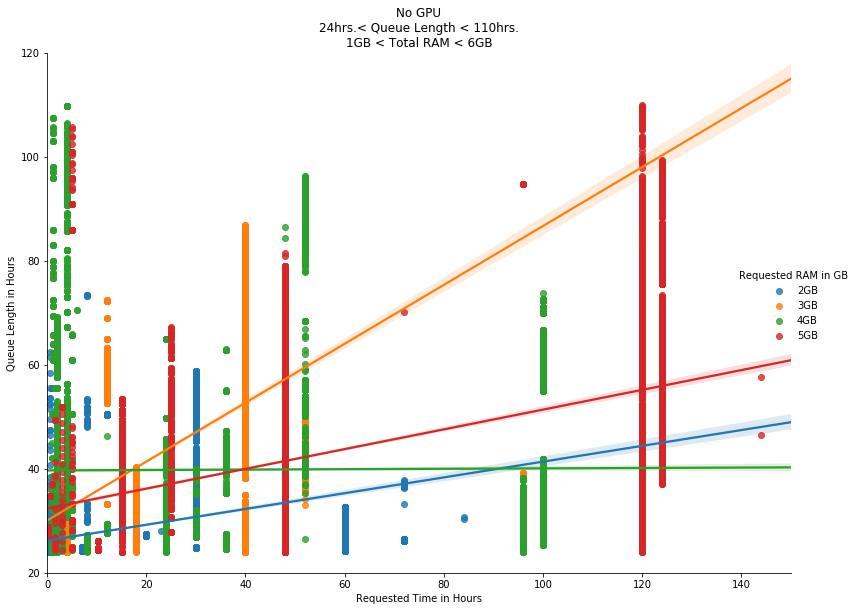

In [28]:
g = sns.lmplot(data=queue_24110_ram_16_nogpu,x='Timelimit',y='queue',hue='total_ram',height=8,aspect=1.4);
plt.title("No GPU\n24hrs.< Queue Length < 110hrs.\n1GB < Total RAM < 6GB")
g._legend.set_title('Requested RAM in GB')
_ = plt.xlabel("Requested Time in Hours")
_ = plt.ylabel("Queue Length in Hours")
_ = plt.xlim(0,150)
_ = plt.ylim(20,120)
for t, l in zip(g._legend.texts, ['2GB','3GB','4GB','5GB']): t.set_text(l)

#### What if we add the GPU nodes back into the subset? Does it change anything?

In [29]:
queue_24110_ram_16['Timelimit'] = queue_24110_ram_16['Timelimit'].apply(add_days)
queue_24110_ram_16['Timelimit'] = pd.to_timedelta(queue_24110_ram_16['Timelimit'])
queue_24110_ram_16['Timelimit'] = queue_24110_ram_16['Timelimit'].apply(lambda x: x/np.timedelta64(1,'h'))
queue_24110_ram_16 = queue_24110_ram_16.loc[queue_24110_ram_16['Timelimit'] < 150]

#### The correlations become a little weaker, but their relationships remain the same.

In [30]:
queue_24110_ram_16[['queue','total_ram','Timelimit']].corr(method="spearman")

,queue,total_ram,Timelimit
queue,1.000000,0.599354,0.739871
total_ram,0.599354,1.000000,0.791951
Timelimit,0.739871,0.791951,1.000000


#### The graph looks almost identical to the one without the GPU nodes in the subset.

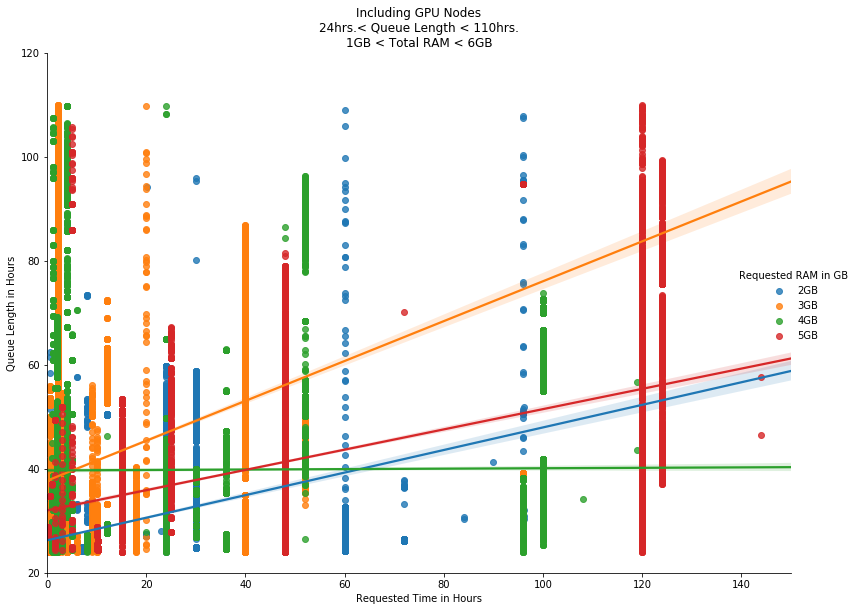

In [31]:
g = sns.lmplot(data=queue_24110_ram_16,x='Timelimit',y='queue',hue='total_ram',height=8,aspect=1.4);
plt.title("Including GPU Nodes\n24hrs.< Queue Length < 110hrs.\n1GB < Total RAM < 6GB")
g._legend.set_title('Requested RAM in GB')
_ = plt.xlabel("Requested Time in Hours")
_ = plt.ylabel("Queue Length in Hours")
_ = plt.xlim(0,150)
_ = plt.ylim(20,120)
for t,l in zip(g._legend.texts, ['2GB','3GB','4GB','5GB']): t.set_text(l)

### Part 2 Bulletpoint Takeways:
* Same subsets seem to correlate with queue length, RAM requests, and wall time requests
* An unexpected finding was that certain RAM requests seem to correlate much stronger with the queue length. It seems that longer wall time does not mean longer queue if the accompanying RAM request is 4GB. On the contrary, 3GB of RAM plus longer wall time is almost guaranteed longer wait times
* Based on the graphs, some variables should have been categorical instead of numerical
* "Be yourself; everyone else is already taken." --Oscar Wilde

## Question 2: Finding Problem Nodes

In [32]:
jobs = pd.DataFrame(job_list_full)
jobs['Submit'] = pd.to_datetime(jobs['Submit'])
jobs['Start'] = pd.to_datetime(jobs['Start'])
jobs['queue'] = jobs['Start'] - jobs['Submit']

In [33]:
jobs = jobs.drop(columns=['JobID', 'ReqGRES', 'UID', 'JobName'])

#### Began by sorting the dataset by jobs with the 'State' of 'NODE_FAIL'

In [34]:
node_fail_jobs = jobs.loc[jobs['State'] == 'NODE_FAIL']
node_fail_jobs = node_fail_jobs.loc[node_fail_jobs['NNodes'] == '1']

#### Created a new dataset with the total number of jobs sorted by 'NodeList'

In [35]:
df_total = pd.DataFrame(jobs.NodeList.value_counts(ascending=False)).reset_index()
df_total = df_total.rename(index = str, columns= {'index':'Node','NodeList':'Total_Jobs'})
df_total.head()

,Node,Total_Jobs
0,None assigned,3470227
1,vmp1409,92419
2,vmp1242,80662
3,vmp1257,74900
4,vmp1001,66221


#### Added a second dataset sorted by 'NodeList' from the list of jobs with the 'State' of 'NODE_FAIL'

In [36]:
df_failed = pd.DataFrame(node_fail_jobs.NodeList.value_counts(ascending=False)).reset_index()
df_failed = df_failed.rename(index = str,  columns= {'index':'Node','NodeList':'Failed_Jobs'})
df_failed.head()

,Node,Failed_Jobs
0,vmp1354,31
1,vmp1350,24
2,vmp1352,22
3,vmp1347,18
4,vmp1349,17


#### Merged the two previous datasets on the column titled 'NodeList' to create a new table comparing 'Failed Jobs' and 'Total Jobs' by Node. This new dataset is called 'df_comb'.

In [37]:
df_comb = pd.merge(df_failed,df_total, on='Node',how='inner')
df_comb.head()

,Node,Failed_Jobs,Total_Jobs
0,vmp1354,31,24104
1,vmp1350,24,21316
2,vmp1352,22,23453
3,vmp1347,18,20360
4,vmp1349,17,19891


#### Created a third column in 'df_comb' consisting of a ratio between 'Failed Jobs' and 'Total Jobs'

In [38]:
df_comb['Ratio']= df_comb['Failed_Jobs']/df_comb['Total_Jobs'] * 100

In [39]:
df_comb=pd.DataFrame(df_comb.sort_values(by=['Ratio'], ascending=False))
df_comb.head(10)

df_comb2 = df_comb.loc[df_comb['Total_Jobs'] >= 1000]
df_comb2.head()

#1000 or more jobs was the main criteria for these nodes, since there were almost 12.5 million jobs attempted over the entire year

df_comb3 = df_comb2.head(100);

#Using only the top 100 nodes on the list because after the top 100, the findings become too small to be considered useful

df_comb3.head(10)

,Node,Failed_Jobs,Total_Jobs,Ratio
58,vmp595,8,1018,0.785855
75,vmp598,7,1042,0.671785
70,vmp592,7,1084,0.645756
76,vmp692,7,1117,0.626679
71,vmp696,7,1118,0.626118
129,vmp695,5,1097,0.455789
120,gpu0010,5,1097,0.455789
135,vmp597,5,1099,0.454959
140,vmp698,5,1147,0.435920
143,gpu0007,5,1198,0.417362


### After creating the column 'Ratio' in 'df_comb', Nodes 'vmp595', 'vmp598', and 'vmp592' appear to have the highest ratio of failed jobs to total number of jobs they executed. 

In [40]:
df_comb3.describe()

,Failed_Jobs,Total_Jobs,Ratio
count,100.000000,100.000000,100.000000
mean,7.020000,7687.250000,0.139856
std,4.801052,5618.317915,0.154887
min,1.000000,1018.000000,0.059095
25%,5.000000,3906.000000,0.066051
50%,5.000000,7608.000000,0.080169
75%,9.000000,8400.250000,0.112788
max,31.000000,25490.000000,0.785855


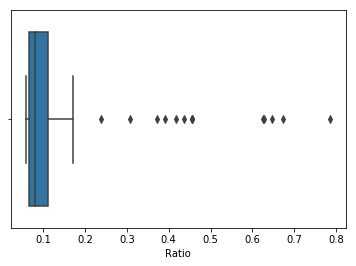

In [41]:
ax = sns.boxplot(x=df_comb3['Ratio'])
ax.set_title=('Ratio Boxplot')

### These summary statistics illustrate that the average failure rate was about 0.14%, while the highest recorded failure rate was about 0.79% and the lowest was 0.06%

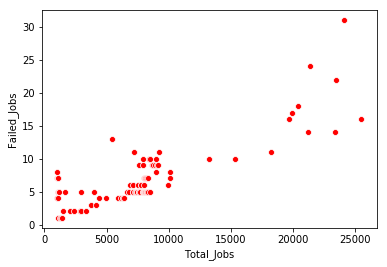

In [42]:
ax = sns.scatterplot(x="Total_Jobs", y="Failed_Jobs", data=df_comb3, color="r")

### Once plotted, there appears to be a strong positive correlation between the total number of jobs and the number of node failures. This finding is supported by the correlation function below. 

In [43]:
df_comb3.corr()

,Failed_Jobs,Total_Jobs,Ratio
Failed_Jobs,1.000000,0.823342,-0.013347
Total_Jobs,0.823342,1.000000,-0.433087
Ratio,-0.013347,-0.433087,1.000000


### Question 2 Bulletpoint Takeaways: 

* Node Failures comprised about 0.14% of all jobs
* Nodes vmp592, vmp595, and vmp598 had the highest ratio of failed jobs to total jobs
* Node vmp595 had the highest failure ratio, at ~0.79%

#### Going forward: 

* Look into specific time periods where there were a large number of  job failures

## Question 3: Finding Problem Users

### Identify specific users that ran greater than 500 jobs, each less than 5 minutes, within a 4 hour window. 
Additionally wanted to see:
* Which groups had the most problematic Users.
* Comparison of jobs with a 'Completed' status vs. all submitted jobs.

#### Converted 'Elapsed' to timedelta format.

In [44]:
job_list_full['Elapsed'] = pd.to_timedelta(job_list_full['Elapsed'])

In [45]:
job_list_full.head(5)

,JobID,JobIDRaw,Cluster,Partition,Account,Group,GID,User,UID,Submit,Eligible,Start,End,Elapsed,ExitCode,State,NNodes,NCPUS,ReqCPUS,ReqMem,ReqGRES,ReqTRES,Timelimit,NodeList,JobName,queue,total_ram
0,15806649,15806649,accre,production,h_vuiis,h_vuiis,36052,masispider,NaN,2017-07-02 00:40:58,2017-07-02T00:42:59,2017-07-03 02:13:59,2017-07-04T03:19:20,-5 days +18:54:39,0:0,COMPLETED,1,2,2,12Gn,NaN,"cpu=2,mem=12G,node=1",9-04:00:00,vmp1085,WOODWARD_TCP-x-228324-x-228324-x-301-x-Multi_A...,1 days 01:33:01,12
1,15806664,15806664,accre,production,h_vuiis,h_vuiis,36052,masispider,NaN,2017-07-02 00:40:58,2017-07-02T00:42:59,2017-07-03 02:20:08,2017-07-04T02:11:55,0 days 23:51:47,0:0,COMPLETED,1,2,2,12Gn,NaN,"cpu=2,mem=12G,node=1",9-04:00:00,vmp1099,WOODWARD_TCP-x-115174-x-115174-x-301-x-Multi_A...,1 days 01:39:10,12
2,15806670,15806670,accre,production,h_vuiis,h_vuiis,36052,masispider,NaN,2017-07-02 00:40:58,2017-07-02T00:42:59,2017-07-03 02:41:13,2017-07-04T04:41:04,-5 days +18:00:09,0:0,COMPLETED,1,2,2,12Gn,NaN,"cpu=2,mem=12G,node=1",9-04:00:00,vmp1126,WOODWARD_TCP-x-215607-x-215607-x-301-x-Multi_A...,1 days 02:00:15,12
3,15806671,15806671,accre,production,h_vuiis,h_vuiis,36052,masispider,NaN,2017-07-02 00:40:58,2017-07-02T00:42:59,2017-07-03 02:51:53,2017-07-04T10:54:13,-5 days +11:57:40,0:0,COMPLETED,1,2,2,12Gn,NaN,"cpu=2,mem=12G,node=1",9-04:00:00,vmp230,WOODWARD_TCP-x-116214-x-116214-x-1701-x-Multi_...,1 days 02:10:55,12
4,15811617,15811617,accre,production,cms_samtest,cms_samtest,59297,uscms010,NaN,2017-07-01 05:00:00,2017-07-01T05:00:00,2017-07-01 05:00:01,2017-07-01T05:00:11,0 days 00:00:10,0:0,COMPLETED,1,1,1,4000Mn,NaN,"cpu=1,mem=4000M,node=1",2-00:00:00,vmp1242,bl_aa7c22e04f21,0 days 00:00:01,4


#### Created subset with only completed jobs.

In [46]:
job_complete = job_list_full.loc[job_list_full['State']== 'COMPLETED'].reset_index()

#### Limited both sets to have only jobs that ran less than 5 minutes.

In [47]:
job_5 = job_complete.loc[job_complete['Elapsed']< pd.to_timedelta('00:05:00')]
job_5_full = job_list_full.loc[job_list_full['Elapsed']< pd.to_timedelta('00:05:00')]

#### Sorted data based on Submit date to prepare data for rolling window.

In [48]:
job_5 = job_5.sort_values(by=['Submit'])
job_5_full = job_5_full.sort_values(by=['Submit'])

#### Got rolling counts of jobs run in 4h windows based on Submit time for each user. Created dataframes of the results to further analyze.

In [49]:
job_5_roll = pd.DataFrame(job_5.groupby('User').rolling('14400s', on='Submit').JobIDRaw.count()).reset_index()
job_5_full_roll = pd.DataFrame(job_5_full.groupby('User').rolling('14400s', on='Submit').JobIDRaw.count()).reset_index()

In [50]:
job_5_roll.rename(index=str, columns={"JobIDRaw": "JobCount"},inplace=True)
job_5_full_roll.rename(index=str, columns={"JobIDRaw": "JobCount"},inplace=True)

#### Limited to users who ran over 500 jobs by selecting any time a user ran 501 jobs within the 4 hour window.

In [51]:
df_job_5_top = job_5_roll.loc[job_5_roll['JobCount']==501]
df_job_5_full_top = job_5_full_roll.loc[job_5_full_roll['JobCount']==501]

#### Created job_group data frame with the distinct Groups and Users from the overall job log and then merged back with both data sets to pull in group that user belongs to.

In [52]:
job_group = job_list_full.groupby(['Group', 'User']).size().reset_index(name='Freq').sort_values(by ='Freq', ascending = False)
job_group = job_group.loc[job_group['Group']!= 'root'] #removed Group 'root' because it was creating duplicate records
job_group = job_group[['Group','User']].reset_index()

df_merge = pd.merge(df_job_5_top,job_group, on='User')
df_merge_full = pd.merge(df_job_5_full_top,job_group, on='User')

#### For each dataset, created two dataframes with aggregated values:
* Number of times the criteria was met per user
* Number of times and number of users that met the criteria per Group

In [53]:
df_prob_users = pd.DataFrame(df_merge[['User','Group','JobCount']].groupby(['User','Group']).agg('count').sort_values(by ='JobCount',ascending=False)).reset_index()
df_prob_group = pd.DataFrame(df_merge[['Group','JobCount','User']].groupby(['Group']).agg({'User':pd.Series.nunique,'JobCount':'count'}).sort_values(by ='JobCount',ascending=False)).reset_index()
df_prob_users_full = pd.DataFrame(df_merge_full[['User','Group','JobCount']].groupby(['User','Group']).agg('count').sort_values(by ='JobCount',ascending=False)).reset_index()
df_prob_group_full = pd.DataFrame(df_merge_full[['Group','JobCount','User']].groupby(['Group']).agg({'User':pd.Series.nunique,'JobCount':'count'}).sort_values(by ='JobCount',ascending=False)).reset_index()

#### Plotted Problematic Users from the full job log.

''

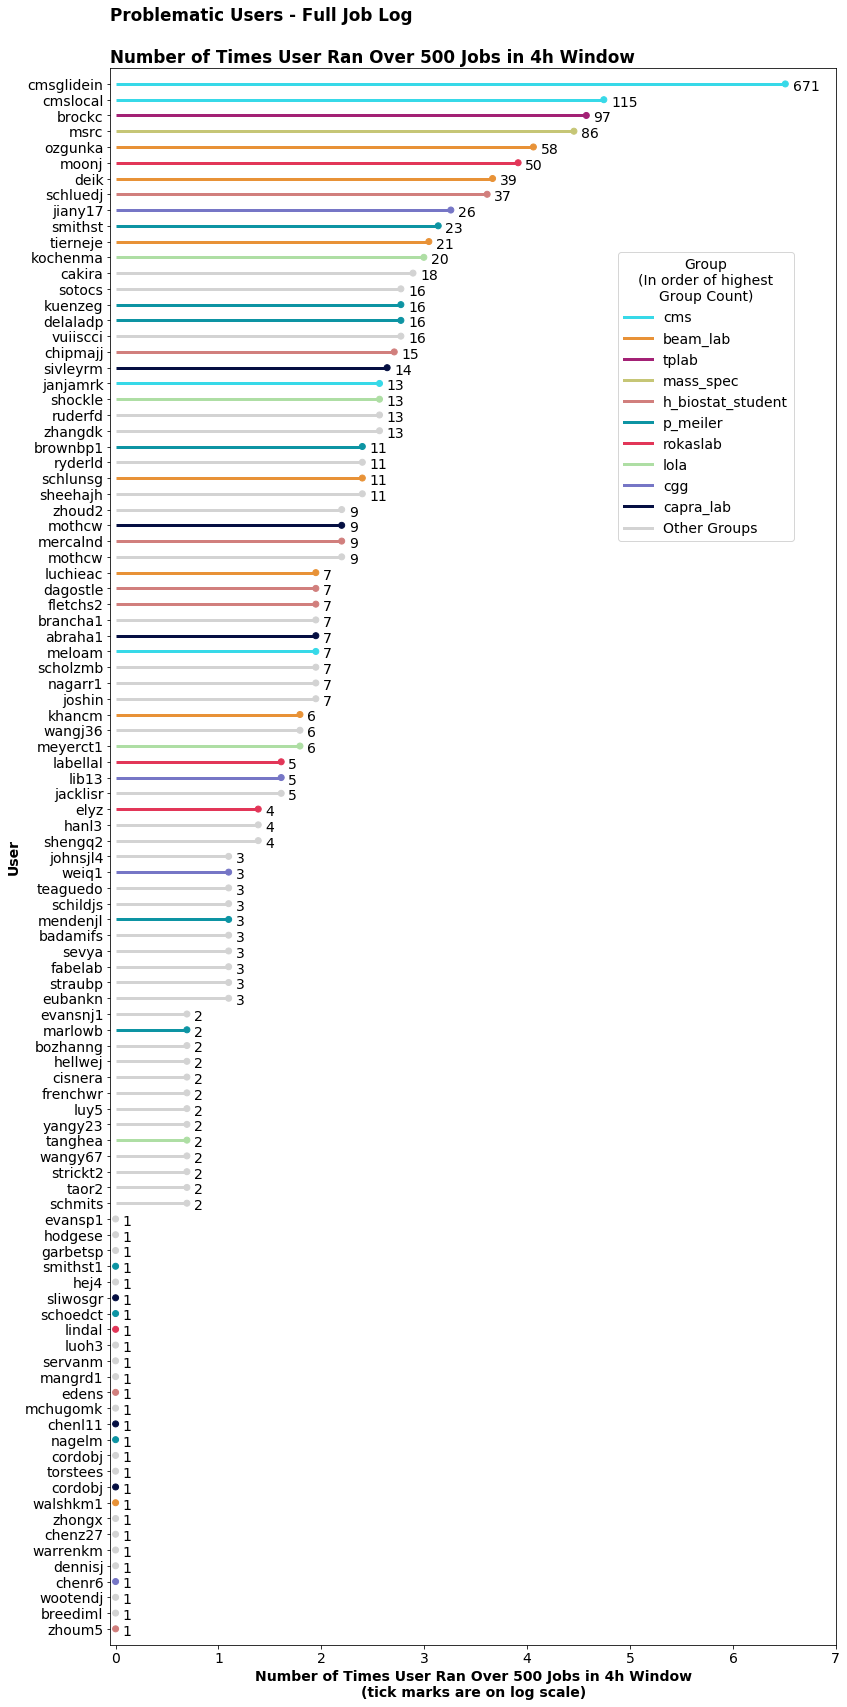

In [54]:
matplotlib.rcParams.update({'font.size': 14})

# For better viewing, took log of value, then reordered df based on values:
df_prob_users_full['JC_resize']=np.log(df_prob_users_full.JobCount)
ordered_df = df_prob_users_full.sort_values(by='JobCount')
my_range=range(1,len(df_prob_users_full.index)+1)

# Vary plotted line colors by Group 
my_color=np.where(ordered_df ['Group']=='cms', '#37d9e8', np.where(ordered_df ['Group']=='beam_lab','#e89237', np.where(ordered_df ['Group']=='tplab','#a32175',np.where(ordered_df ['Group']=='mass_spec','#c6c676',np.where(ordered_df ['Group']=='h_biostat_student','#d17f7d',np.where(ordered_df ['Group']=='p_meiler','#0d94a3',np.where(ordered_df ['Group']=='rokaslab','#e23658',np.where(ordered_df ['Group']=='lola','#aedea4',np.where(ordered_df ['Group']=='cgg','#7676c6',np.where(ordered_df ['Group']=='capra_lab','#050f42','#d3d3d3'))))))))))

# Plot data
fig, ax = plt.subplots()
fig.set_size_inches(13,29)
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['JC_resize'], color=my_color,linewidth=3)
ax=plt.scatter(ordered_df['JC_resize'], my_range, color=my_color, alpha=1)

# Add titles and axis names
plt.yticks(my_range, ordered_df['User'])
plt.title("Problematic Users - Full Job Log\n\nNumber of Times User Ran Over 500 Jobs in 4h Window", loc='left',fontweight = 'bold')
plt.xlabel('Number of Times User Ran Over 500 Jobs in 4h Window\n(tick marks are on log scale)',fontweight = 'bold')
plt.ylabel('User',fontweight = 'bold')
plt.ylim((0,len(df_prob_users_full.index)+1))
plt.xlim((-0.05,7))

# Custom legend
custom_lines = [Line2D([0], [0], color='#37d9e8', lw=3),
                Line2D([0], [0], color='#e89237', lw=3),
                Line2D([0], [0], color='#a32175', lw=3),
                Line2D([0], [0], color='#c6c676', lw=3),
                Line2D([0], [0], color='#d17f7d', lw=3),
                Line2D([0], [0], color='#0d94a3', lw=3),
                Line2D([0], [0], color='#e23658', lw=3),
                Line2D([0], [0], color='#aedea4', lw=3),
                Line2D([0], [0], color='#7676c6', lw=3),
                Line2D([0], [0], color='#050f42', lw=3),
                Line2D([0], [0], color='#d3d3d3', lw=3)]
l = plt.legend(custom_lines
               , ['cms', 'beam_lab', 'tplab','mass_spec','h_biostat_student','p_meiler','rokaslab','lola','cgg','capra_lab','Other Groups']
               ,loc=(.7,.7)
               ,title ='Group\n(In order of highest\nGroup Count)')
plt.setp(l.get_title(),multialignment='center')

# Annotate with actual values
for i,j,k in zip(ordered_df['JC_resize'],my_range,ordered_df['JobCount']):
    plt.annotate(str(k),xy=(i+0.07,j-0.4))
;

In [55]:
print('\n'+'\033[1m'+'Looking at the full job log:\n'+'\033[0m'+' - Out of '+str(job_list_full['User'].nunique())+' overall users, there are '+'\033[1m'+str(df_prob_users_full['User'].nunique())+'\033[0m'+' users that met the criteria.')
print(' - The '+'\033[1m'+str(pd.DataFrame(df_prob_group_full.nlargest(1,'JobCount')).iloc[0,0])+'\033[0m'+' group met the criteria the most with '+'\033[1m'+str(pd.DataFrame(df_prob_group_full.nlargest(1,'JobCount')).iloc[0,1])+'\033[0m'+' number of times.')
print(' - The '+'\033[1m'+str(pd.DataFrame(df_prob_group_full.nlargest(1,'User')).iloc[0,0])+'\033[0m'+' group had the most users meet the criteria with '+'\033[1m'+str(pd.DataFrame(df_prob_group_full.nlargest(1,'User')).iloc[0,2])+'\033[0m'+' users.\n')


Looking at the full job log:
 - Out of 496 overall users, there are 97 users that met the criteria.
 - The cms group met the criteria the most with 4 number of times.
 - The p_meiler group had the most users meet the criteria with 74 users.



#### Plotted Problematic Users from Complete Jobs list.

''

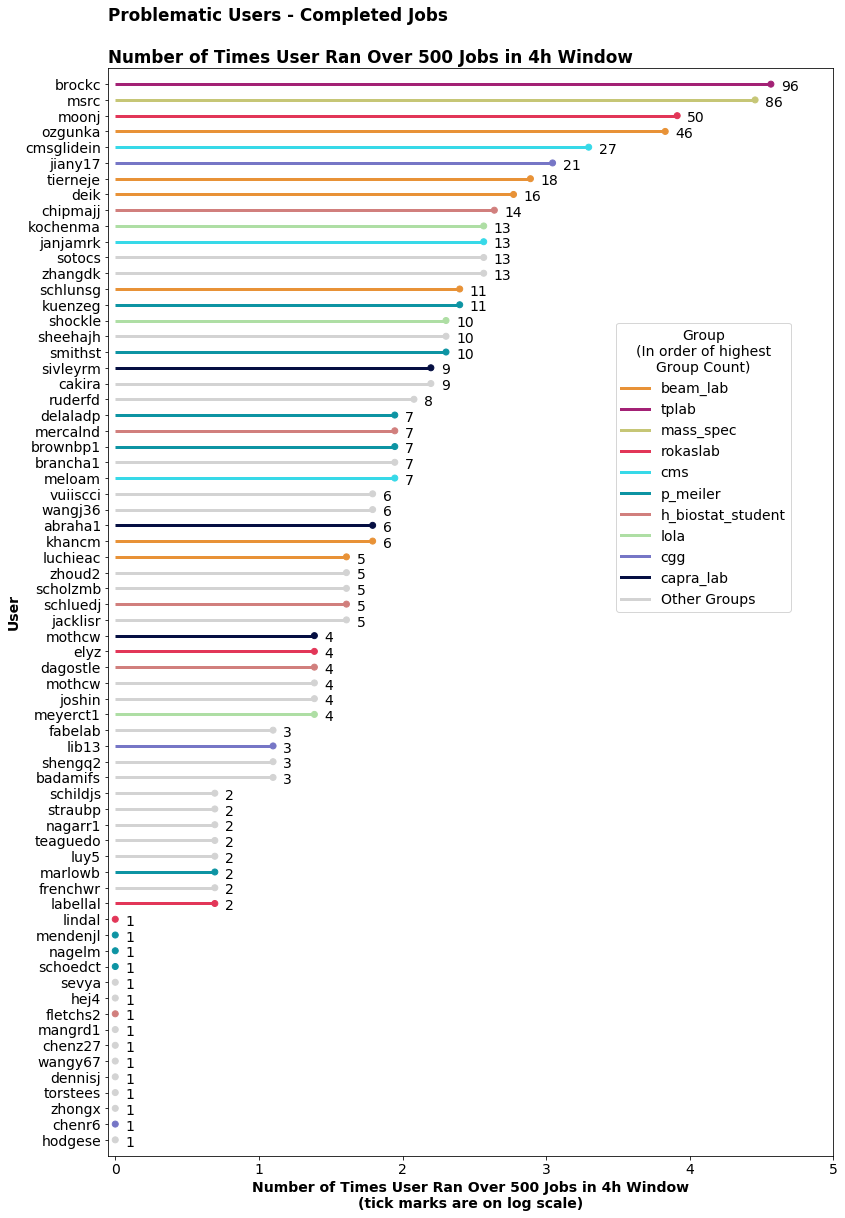

In [56]:
# For better viewing, took log of value, then reordered df based on values:
df_prob_users['JC_resize']=np.log(df_prob_users.JobCount)
ordered_df = df_prob_users.sort_values(by='JobCount')
my_range=range(1,len(df_prob_users.index)+1)
 
# Vary plotted line colors by Group 
my_color=np.where(ordered_df ['Group']=='cms', '#37d9e8', np.where(ordered_df ['Group']=='beam_lab','#e89237', np.where(ordered_df ['Group']=='tplab','#a32175',np.where(ordered_df ['Group']=='mass_spec','#c6c676',np.where(ordered_df ['Group']=='h_biostat_student','#d17f7d',np.where(ordered_df ['Group']=='p_meiler','#0d94a3',np.where(ordered_df ['Group']=='rokaslab','#e23658',np.where(ordered_df ['Group']=='lola','#aedea4',np.where(ordered_df ['Group']=='cgg','#7676c6',np.where(ordered_df ['Group']=='capra_lab','#050f42','#d3d3d3'))))))))))

# Plot data
fig, ax = plt.subplots()
fig.set_size_inches(13,20)
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['JC_resize'], color=my_color,linewidth=3)
ax=plt.scatter(ordered_df['JC_resize'], my_range, color=my_color, alpha=1)

# Add titles and axis names
plt.yticks(my_range, ordered_df['User'])
plt.title("Problematic Users - Completed Jobs\n\nNumber of Times User Ran Over 500 Jobs in 4h Window", loc='left',fontweight = 'bold')
plt.xlabel('Number of Times User Ran Over 500 Jobs in 4h Window\n(tick marks are on log scale)',fontweight = 'bold')
plt.ylabel('User',fontweight = 'bold')
plt.ylim((0,len(df_prob_users.index)+1))
plt.xlim((-0.05,5))

# Custom Legend
custom_lines = [
                Line2D([0], [0], color='#e89237', lw=3),
                Line2D([0], [0], color='#a32175', lw=3),
                Line2D([0], [0], color='#c6c676', lw=3),
                Line2D([0], [0], color='#e23658', lw=3),
                Line2D([0], [0], color='#37d9e8', lw=3),
                Line2D([0], [0], color='#0d94a3', lw=3),
                Line2D([0], [0], color='#d17f7d', lw=3),
                Line2D([0], [0], color='#aedea4', lw=3),
                Line2D([0], [0], color='#7676c6', lw=3),
                Line2D([0], [0], color='#050f42', lw=3),
                Line2D([0], [0], color='#d3d3d3', lw=3)]
l = plt.legend(custom_lines
               , [ 'beam_lab', 'tplab','mass_spec','rokaslab','cms','p_meiler','h_biostat_student','lola','cgg','capra_lab','Other Groups']
               ,loc=(.7,.5)
               ,title ='Group\n(In order of highest\nGroup Count)')
plt.setp(l.get_title(),multialignment='center')

# Annotate with actual values
for i,j,k in zip(ordered_df['JC_resize'],my_range,ordered_df['JobCount']):
    plt.annotate(str(k),xy=(i+0.07,j-0.4))
;

In [57]:
print('\n'+'\033[1m'+'Looking at only completed jobs:\n'+'\033[0m'+' - Out of '+str(job_complete['User'].nunique())+' overall users, there are '+'\033[1m'+str(df_prob_users['User'].nunique())+'\033[0m'+' users that met the criteria.')
print(' - The '+'\033[1m'+str(pd.DataFrame(df_prob_group.nlargest(1,'JobCount')).iloc[0,0])+'\033[0m'+' group met the criteria the most with '+'\033[1m'+str(pd.DataFrame(df_prob_group.nlargest(1,'JobCount')).iloc[0,1])+'\033[0m'+' times.')
print(' - The '+'\033[1m'+str(pd.DataFrame(df_prob_group.nlargest(1,'User')).iloc[0,0])+'\033[0m'+' group had the most users meet the criteria with '+'\033[1m'+str(pd.DataFrame(df_prob_group.nlargest(1,'User')).iloc[0,2])+'\033[0m'+' users.')


Looking at only completed jobs:
 - Out of 475 overall users, there are 67 users that met the criteria.
 - The beam_lab group met the criteria the most with 6 times.
 - The p_meiler group had the most users meet the criteria with 40 users.


### Question 3 Bulletpoint Takeways:

* 19.6% of users met the criteria of being a problematic user at least once, with cmsglidein appearing to be the most problematic user.
* 14.1% of users with completed jobs met the criteria at least once, with brockc as the most problematic user.
* Overall, the p_meiler group had the most problematic users, but the users did not meet the criteria as frequently.

Future Work
* Better understand the difference between users with completed job runs vs. overall job runs.
* Look further into the number of jobs run within each 4 hour window.